In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv("Data/final_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.head()

,Price_eth,addresses_active_count_onchain,RevUSD_market,Vader_Comp,Vol._futures,Vader_Neu,bids_market,supply_miner_held_by_all_addresses_within_one_hop_of_a_mining_entity_native_units_onchain,volatility_market,AdrActCnt_market,...,estimated_transaction_volume_usd_onchain,bidAskSpread_market,hash_rate_mean_onchain,HashRate_market,TxCnt_market,VtyDayRet30d_market,supply_held_by_top_100_addresses_onchain,Vader_Neg,target,test
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-05,1099.52,1230529,55986515.21,0.20215,8150.0,0.854741,2.696802e+07,2822587.597,186.406136,1040203.0,...,6.775408e+09,0.599972,145160753.6,1.582156e+08,260173.0,0.034317,2481892.551,0.039323,1.612101,False
2021-01-06,1207.77,1344921,34231235.25,0.20215,19470.0,0.854741,3.261763e+07,2822077.477,184.314315,914351.0,...,7.549977e+09,0.583837,163652569.0,1.485729e+08,231423.0,0.054134,2474776.497,0.039323,1.535109,False
2021-01-07,1224.35,1292297,22532356.46,0.20215,16830.0,0.854741,3.224854e+07,2821826.388,217.307109,817115.0,...,9.896770e+09,0.643784,155331252.4,9.512298e+07,232056.0,0.051059,2486440.508,0.039323,0.661790,False
2021-01-08,1215.73,1237271,38861905.57,0.20215,15380.0,0.854741,3.492305e+07,2822390.243,265.300557,695892.0,...,8.838844e+09,0.682708,136839436.2,1.109758e+08,190234.0,0.030858,2501364.372,0.039323,-2.878639,False
2021-01-11,1091.47,1211948,57409115.37,0.20215,22210.0,0.854741,3.533249e+07,2821437.198,434.242095,1053426.0,...,6.926937e+09,0.975458,157757649.3,1.593504e+08,289324.0,0.030561,2506447.879,0.039323,-0.828492,False


In [3]:
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag="AIC")
    p_value = result[1]
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {p_value}")
    if p_value <= 0.05:
        print("Stationary (Reject H0)")
    else:
        print("Non-Stationary (Fail to reject H0)")


test_stationarity(df["target"])

ADF Statistic: -26.38078201739956
p-value: 0.0
Stationary (Reject H0)


In [4]:
price_series = df["target"]

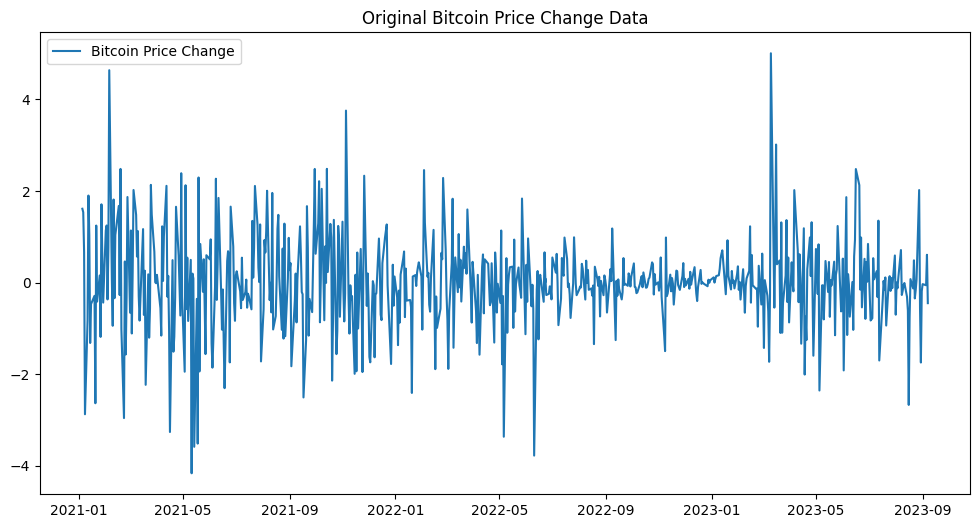

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(price_series, label="Bitcoin Price Change")
plt.title("Original Bitcoin Price Change Data")
plt.legend()
plt.show()

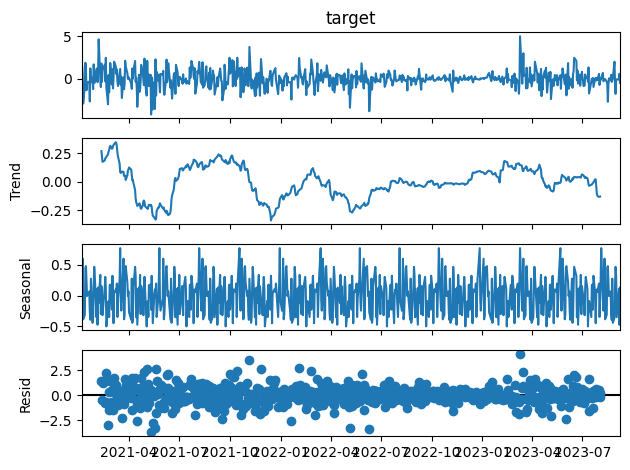

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(price_series, model="additive", period=50)
result.plot()
plt.show()

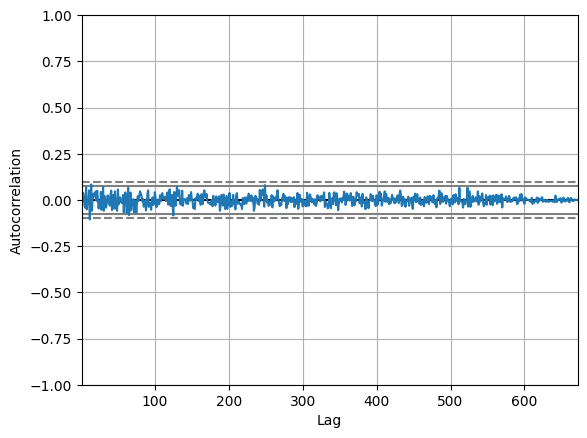

In [7]:
# Check autocorrelation
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(price_series)
plt.show()

C:\Users\JunYou\AppData\Local\Temp\ipykernel_19432\1713203532.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(y[i])


MSE: 1.0024448640652233
MAE: 0.6904145676920591
RMSE: 1.0012216857745457


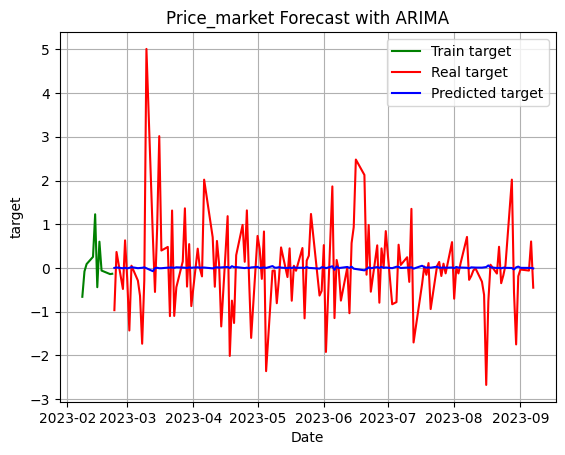

In [8]:
train_data = df[df["test"] == False]
test_data = df[df["test"] == True]

train_arima = train_data["target"]
test_arima = test_data["target"]

history = [x for x in train_arima]
y = test_arima

# make first prediction
predictions = list()
for i in range(len(y)):
    model = ARIMA(history, order=(1, 0, 0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(y[i])

# report performance
mse = mean_squared_error(y, predictions)
print("MSE: " + str(mse))
mae = mean_absolute_error(y, predictions)
print("MAE: " + str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print("RMSE: " + str(rmse))

# Plot the actual vs. predicted stock prices
plt.plot(
    train_data.index[-10:],
    train_data["target"].tail(10),
    color="green",
    label="Train target",
)
plt.plot(test_data.index, y, color="red", label="Real target")
plt.plot(test_data.index, predictions, color="blue", label="Predicted target")
plt.title("Price_market Forecast with ARIMA")
plt.xlabel("Date")
plt.ylabel("target")
plt.legend()
plt.grid(True)
# plt.savefig("arima_model.png")
plt.show()